# Code for Fig. SM 7

In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from scipy.interpolate import CubicSpline
import copy

from general_functions import (complete_dynamics, compute_shift)

## Single layer

### Individual

In [23]:
pol_lat = np.array([[0, 1, 0]]).T
pol_emi = [np.array([[1, 1, 0]] / np.sqrt(3)).T]

d = 1 # Wave-lenght of transition
lambda0 = d / 0.3 # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

border = 10
max_gamma = 10

N_x = 60
N_y = N_x
x_pos = np.arange(0, N_x) - N_x / 2 + d / 2
y_pos = np.arange(0, N_y) - N_y / 2 + d / 2
x_pos, y_pos = np.meshgrid(x_pos, y_pos)
x_pos = x_pos.flatten()
y_pos = y_pos.flatten()
z_pos = np.zeros(len(x_pos))
r_pos = [x_pos, y_pos, z_pos]

gamma_emi = 0.002
omega_emi = -0.999  # For d / lambda_0 = 0.3

dt = 2e-3 / gamma_emi
tf = dt * 2 ** 10

psi0 = np.zeros(len(x_pos) + 1)
psi0[-1] = 1

emitter = [[0, 0, 0]]

In [24]:
results = complete_dynamics([x_pos, y_pos, z_pos], k0, pol_lat, dt, tf, psi0, 
                            emitter= emitter, pol_emi=pol_emi, gamma_emi=gamma_emi,
                            omega_emi=omega_emi, border=border, max_gamma=max_gamma)

population_ind = np.abs(results['psi'][:, -1]) ** 2

### Collective

In [25]:
de = 14.14 * d
emitter = [[-de / np.sqrt(2) / 2, de / np.sqrt(2) / 2, 0],
           [de / np.sqrt(2) / 2, -de / np.sqrt(2) / 2, 0]]

n_e = 2
signs = [1, 1]
psi0 = np.zeros(N_x * N_y + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)

In [26]:
results = complete_dynamics([x_pos, y_pos, z_pos], k0, pol_lat, dt, tf, psi0, 
                            emitter=emitter, pol_emi=pol_emi * 2, gamma_emi=gamma_emi,
                            omega_emi=omega_emi, border=border, max_gamma=max_gamma)

population_coll = np.sum(np.abs(results['psi'][:, -n_e:]) ** 2, axis=-1)

population = np.abs(results['psi'][:, :-n_e].reshape((-1, N_y, N_x))) ** 2
index_max = np.argmax(np.sum(population, axis=(1, 2)))
real_space_emission = population[index_max]

Text(0, 0.5, 'population')

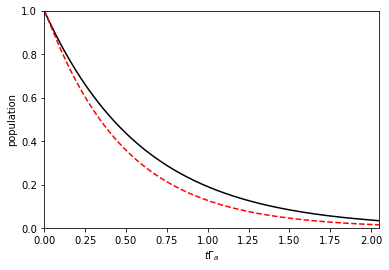

In [27]:
fig, ax = plt.subplots()

ax.plot(results['time'] * gamma_emi, population_ind, 'k', label='individual')
ax.plot(results['time'] * gamma_emi, population_coll, 'r--', label='collective')
ax.set_ylim(0, 1)
ax.set_xlim(0, tf * gamma_emi)
ax.set_xlabel(r'$t\Gamma_a$')
ax.set_ylabel('population');

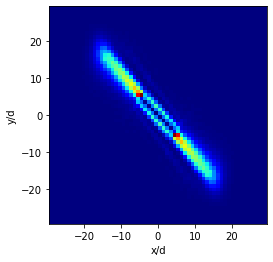

In [28]:
fig, ax = plt.subplots()
ax.imshow(real_space_emission, origin='lower', aspect='equal', cmap='jet',
          extent=[min(x_pos), max(x_pos), min(y_pos), max(y_pos)], vmin=0)

ax.set_xlabel('x/d')
ax.set_ylabel('y/d');

## Cluster

### Individual

In [29]:
dc = 0.45 * d
emitter = [[-dc / np.sqrt(2), dc / np.sqrt(2), 0],
           [dc / np.sqrt(2), -dc / np.sqrt(2), 0]]

n_e = 2
signs = [1, 1]
psi0 = np.zeros(N_x * N_y + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)

shift = compute_shift(emitter[0], emitter[1], pol_emi[0], pol_emi[0], k0, gamma_emi, psi0[-2:])

In [30]:
results = complete_dynamics([x_pos, y_pos, z_pos], k0, pol_lat, dt, tf, psi0, 
                            emitter=emitter, pol_emi=pol_emi * n_e, gamma_emi=gamma_emi,
                            omega_emi=omega_emi - np.real(shift), border=border,
                            max_gamma=max_gamma)

population_ind = np.sum(np.abs(results['psi'][:, -n_e:]) ** 2, axis=-1)

### Collective

In [31]:
dc = 0.45 * d
n_plaquette = 5
emitter = [[n_plaquette + -dc / np.sqrt(2), n_plaquette + dc / np.sqrt(2), 0],
           [n_plaquette + dc / np.sqrt(2),  n_plaquette -dc / np.sqrt(2), 0],
           [-n_plaquette + -dc / np.sqrt(2), -n_plaquette + dc / np.sqrt(2), 0],
           [-n_plaquette + dc / np.sqrt(2),  -n_plaquette -dc / np.sqrt(2), 0]]

n_e = 4
signs = [1, 1, 1, 1]
psi0 = np.zeros(N_x * N_y + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)

shift = compute_shift(emitter[0], emitter[1], pol_emi[0], pol_emi[0], k0, gamma_emi, psi0[-2:])

In [32]:
results = complete_dynamics([x_pos, y_pos, z_pos], k0, pol_lat, dt, tf, psi0, 
                            emitter=emitter, pol_emi=pol_emi * n_e, gamma_emi=gamma_emi,
                            omega_emi=omega_emi - np.real(shift), border=border,
                            max_gamma=max_gamma)

population_coll = np.sum(np.abs(results['psi'][:, -n_e:]) ** 2, axis=-1)

population = np.abs(results['psi'][:, :-n_e].reshape((-1, N_y, N_x))) ** 2
index_max = np.argmax(np.sum(population, axis=(1, 2)))
real_space_emission = population[index_max]

Text(0, 0.5, 'population')

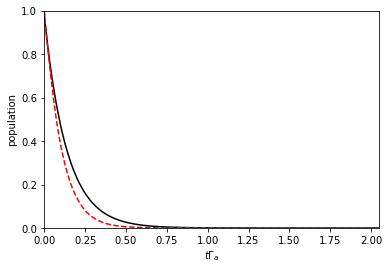

In [33]:
fig, ax = plt.subplots()

ax.plot(results['time'] * gamma_emi, population_ind, 'k', label='individual')
ax.plot(results['time'] * gamma_emi, population_coll, 'r--', label='collective')
ax.set_ylim(0, 1)
ax.set_xlim(0, tf * gamma_emi)
ax.set_xlabel(r'$t\Gamma_a$')
ax.set_ylabel('population');

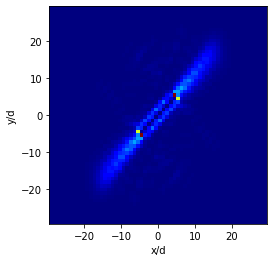

In [34]:
fig, ax = plt.subplots()
ax.imshow(real_space_emission, origin='lower', aspect='equal', cmap='jet',
          extent=[min(x_pos), max(x_pos), min(y_pos), max(y_pos)], vmin=0)

ax.set_xlabel('x/d')
ax.set_ylabel('y/d');

## Bilayer

In [3]:
data = np.load('divergence_energy_bilayer_shift.npy', allow_pickle=True).item()
omega_X_int = CubicSpline(data['z_vec'], data['omega_X'])

### Individual

In [4]:
pol_lat = np.array([[1, 1, 0]] / np.sqrt(2)).T
pol_emi = [np.array([[0, 1, 0]]).T]

border = 10 # Border of adiabatic lossees
gamma_max = 10  # Maximum individual free space decay rate in the border

d = 1 # Wave-lenght of transition
lambda0 = d / 0.3 # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

border = 10
max_gamma = 10

db = 0.1 * d
shift = np.array([0.5, 0.5, db]) # Displacement vector

N_x = 50
N_y = N_x
x_pos_A = (np.arange(0, N_x) - N_x / 2 + d / 2)
y_pos_A = (np.arange(0, N_y) - N_y / 2 + d / 2)
x_pos_A, y_pos_A = [x.flatten() for x in np.meshgrid(x_pos_A, y_pos_A)]
z_pos_A = np.zeros(np.shape(x_pos_A))
n_A = len(x_pos_A)

x_pos_B = x_pos_A + shift[0]
y_pos_B = y_pos_A + shift[1]
z_pos_B = z_pos_A + shift[2]
n_B = len(x_pos_B)

x_pos = np.append(x_pos_A, x_pos_B)
y_pos = np.append(y_pos_A, y_pos_B)
z_pos = np.append(z_pos_A, z_pos_B)
r_pos = [x_pos, y_pos, z_pos]

emitter = [[0.5, 0, db / 2]]
n_e = 1

psi0 = np.zeros(len(x_pos) + 1)
psi0[-1] = 1

gamma_emi = 0.002
omega_emi = omega_X_int(db)

dt = 2e-3 / gamma_emi
tf = dt * 2 ** 10

In [5]:
results = complete_dynamics([x_pos, y_pos, z_pos], k0, pol_lat, dt, tf, psi0, 
                            emitter=emitter, pol_emi=pol_emi * n_e, gamma_emi=gamma_emi,
                            omega_emi=omega_emi, border=border, max_gamma=max_gamma)

population_ind = np.sum(np.abs(results['psi'][:, -n_e:]) ** 2, axis=-1)

population = np.abs(results['psi'][:, :n_A].reshape((-1, N_y, N_x))) ** 2
index_max = np.argmax(np.sum(population, axis=(1, 2)))
real_space_emission = population[index_max]

### Collective

In [6]:
n_plaquette = 4
emitter = [[n_plaquette, n_plaquette + 0.5, shift[2] / 2],
           [-n_plaquette, -n_plaquette + 0.5, shift[2] / 2]]
n_e = 2

signs = [1, 1]
psi0 = np.zeros(n_A + n_B + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)

In [7]:
angle_target = 57.6 / 180 * np.pi
counter = 0
while True:
    previous = copy.deepcopy(emitter)
    theta = np.arctan((emitter[0][1] - emitter[1][1]) / (emitter[0][0] - emitter[1][0]))
    if theta < angle_target:
        desp = -1
    else:
        desp = 1
    if counter % 2 == 0:
        emitter[1][1] += desp
    else:
        emitter[0][1] -= desp
    theta_new = np.arctan((emitter[0][1] - emitter[1][1]) / (emitter[0][0] - emitter[1][0]))
    if np.abs(theta_new - angle_target) > np.abs(theta - angle_target):
        emitter = previous[:]
        break
    else:
        counter += 1
        pass

d_e = np.sqrt((emitter[0][0] - emitter[1][0]) ** 2 + (emitter[0][1] - emitter[1][1]) ** 2)
print('Distance between emitters: {:.3f} d'.format(d_e))

Distance between emitters: 15.264 d


In [8]:
results = complete_dynamics([x_pos, y_pos, z_pos], k0, pol_lat, dt, tf, psi0, 
                            emitter=emitter, pol_emi=pol_emi * n_e, gamma_emi=gamma_emi,
                            omega_emi=omega_emi, border=border, max_gamma=max_gamma)

population_coll = np.sum(np.abs(results['psi'][:, -n_e:]) ** 2, axis=-1)

population = np.abs(results['psi'][:, :n_A].reshape((-1, N_y, N_x))) ** 2
index_max = np.argmax(np.sum(population, axis=(1, 2)))
real_space_emission = population[index_max]

Text(0, 0.5, 'population')

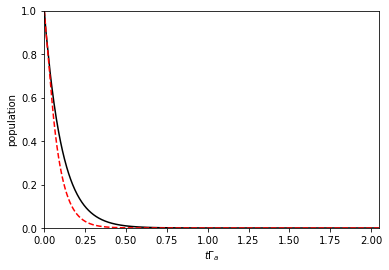

In [9]:
fig, ax = plt.subplots()

ax.plot(results['time'] * gamma_emi, population_ind, 'k', label='individual')
ax.plot(results['time'] * gamma_emi, population_coll, 'r--', label='collective')
ax.set_ylim(0, 1)
ax.set_xlim(0, tf * gamma_emi)
ax.set_xlabel(r'$t\Gamma_a$')
ax.set_ylabel('population');

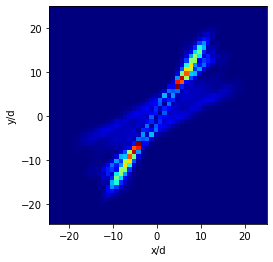

In [11]:
fig, ax = plt.subplots()
ax.imshow(real_space_emission, origin='lower', aspect='equal', cmap='jet',
          extent=[min(x_pos), max(x_pos), min(y_pos), max(y_pos)], vmin=0)

ax.set_xlabel('x/d')
ax.set_ylabel('y/d');